In [1]:
import numpy as np
import pickle

from scipy.stats import spearmanr, pearsonr, rankdata
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import scipy
scipy.__version__

'1.7.3'

# load explanations

In [3]:
#load explanations

#lime
method='lime'
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']
n=3000

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_lime = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#kernelshap
method='kernelshap'
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_kernelshap = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#vanillagrad
method='vanillagrad'
model_names = ['nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_vanillagrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#gradient*input
method='gradtinput'
model_names = ['nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_gradtinput = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#integrated gradients
method='integratedgrad'
model_names = ['nn', 'nn_logistic']
n=1500

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_integratedgrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#smoothgrad
method='smoothgrad'
model_names = ['nn', 'nn_logistic']
n=1500

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_smoothgrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


# calculate metric for one method pair

## rank correlation

In [4]:
#rank correlation

def rankcorr(attrA, attrB):
    '''
    attrA: np.array, n x p
    attrB: np.array, n x p
    '''
    corrs = []
    #rank features (accounting for ties)
    all_feat_ranksA = rankdata(-np.abs(attrA), method='dense', axis=1) #rankdata gives rank1 for smallest # --> we want rank1 for largest # (aka # with largest magnitude)
    all_feat_ranksB = rankdata(-np.abs(attrB), method='dense', axis=1) 
    for row in range(attrA.shape[0]):
        #calculate correlation on ranks (iterate through rows: https://stackoverflow.com/questions/44947030/how-to-get-scipy-stats-spearmanra-b-compute-correlation-only-between-variable)
        rho, _ = pearsonr(all_feat_ranksA[row, :], all_feat_ranksB[row, :]) 
        corrs.append(rho)    
    return np.array(corrs), np.mean(corrs) #return metric's distribution and average




## pairwise metric --> TODO

In [5]:
def pairwise(attrA, attrB):
    
    '''
    inputs
    attrA: np.array, n x p
    attrB: np.array, n x p
    
    outputs:
    pairwise_distr: 1D numpy array (dimensions=(n,)) of pairwise comparison agreement for each data point
    pairwise_avg: mean of pairwise_distr
    '''
    
    return pairwise_distr, pairwise_avg

## 4 agreement metrics

In [6]:
def agreement_fraction(attrA, attrB, k, metric_type=['overlap', 'rank', 'sign', 'ranksign']):
    
    #id of top-k features
    topk_idA = np.argsort(-np.abs(attrA), axis=1)[:, 0:k]
    topk_idB = np.argsort(-np.abs(attrB), axis=1)[:, 0:k]

    #rank of top-k features
    topk_ranks = np.array(range(0, k)) #by definition, topk features are ranked 0, ..., k

    #sign of top-k features
    topk_signA = np.take_along_axis(np.sign(attrA), topk_idA, axis=1)  #pos=1; neg=-1
    topk_signB = np.take_along_axis(np.sign(attrB), topk_idB, axis=1)  

    #overlap agreement = (# topk features in common)/k
    if metric_type=='overlap':
        topk_setsA = [set(row) for row in topk_idA]
        topk_setsB = [set(row) for row in topk_idB]
        metric_distr = [len(setA.intersection(setB))/k for setA, setB in zip(topk_setsA, topk_setsB)] 
        metric_distr = np.array(metric_distr)

    #rank agreement
    elif metric_type=='rank':    
        #rank of top-k features --> manually calculate rankings (instead of using 0, 1, ..., k ranking based on argsort output) to account for ties
        all_feat_ranksA = rankdata(-np.abs(attrA), method='dense', axis=1) #rankdata gives rank1 for smallest # --> we want rank1 for largest # (aka # with largest magnitude)
        all_feat_ranksB = rankdata(-np.abs(attrB), method='dense', axis=1) 
        topk_ranksA = np.take_along_axis(all_feat_ranksA, topk_idA, axis=1) 
        topk_ranksB = np.take_along_axis(all_feat_ranksB, topk_idB, axis=1)
        topk_id_ranksA = np.stack([topk_idA, topk_ranksA], axis=2)
        topk_id_ranksB = np.stack([topk_idA, topk_ranksB], axis=2)
        same_id_rank = (topk_id_ranksA == topk_id_ranksB).sum(axis=2) == 2 #features (for each data point) that have same id and rank
        metric_distr = same_id_rank.sum(axis=1)/k #same feature id and rank

    #sign agreement
    elif metric_type=='sign':    
        topk_id_signA = np.multiply(topk_idA, topk_signA)
        topk_id_signB = np.multiply(topk_idB, topk_signB)
        metric_distr = (topk_id_signA == topk_id_signB).sum(axis=1)/k #same feature id and sign

    #rank and sign agreement
    elif metric_type=='ranksign':    
        same_rank = topk_idA == topk_idB
        same_sign = topk_signA == topk_signB
        metric_distr = np.logical_and(same_rank, same_sign).sum(axis=1)/k #same feature id, rank, and sign

    return metric_distr, np.mean(metric_distr)
    
    

# calculate metrics for all method pairs + plot

In [7]:
def metric_all_methodpairs(expl_methods_names, expl_methods_attrs, k,
                           metric_type=['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign']):
    '''
    inputs
    expl_methods_names: dictionary with string names of explanation methods (keys=method_index, values=method_name_string)
    expl_methods_attrs: dictionary of attributions (keys=method_index, values=attributions for a model)
    
    outputs
    method_pairs_distr: dictionary with distribution of rank correlation for each method pair (keys=method pair, values=1D array of metric values for each datapoint)
    method_pairs_avg: array with average rank correlation for each pair of methods
    '''
    #initiate dict to store distribution of metric for each method pair
    method_pairs_distr = {}
    
    #initiate array to store average of metric for each method pair
    num_expl_methods = len(expl_methods_attrs)
    method_pairs_avg = np.zeros([num_expl_methods, num_expl_methods])
    
    #fill corr_distr and avg_corr_matrix 
    for a, b in itertools.combinations_with_replacement(range(num_expl_methods), 2):
        #print(f'calculating {expl_methods_names[a]} ({a}) and {expl_methods_names[b]} ({b})')
        
        #calculate metric for one method pair
        if metric_type=='rankcorr': 
            metric_distr, metric_avg = rankcorr(attrA=expl_methods_attrs[a], attrB=expl_methods_attrs[b])

#         #!!!!TODO
#         elif metric_type=='pairwise':
#             metric_distr, metric_avg = pairwise_comp(attrA=expl_methods_attrs[a], attrB=expl_methods_attrs[b])

        elif metric_type in ['overlap', 'rank', 'sign', 'ranksign']: 
            metric_distr, metric_avg = agreement_fraction(attrA=expl_methods_attrs[a], attrB=expl_methods_attrs[b], k=k, metric_type=metric_type)

        #store metric distribution in dictionary
        if a != b:
            method_pairs_distr[f'{expl_methods_names[a]} vs. {expl_methods_names[b]}'] = metric_distr
        
        #store metric average in array
        method_pairs_avg[a, b] = metric_avg
        method_pairs_avg[b, a] = metric_avg
        
    return method_pairs_distr, method_pairs_avg
    

# plotting

In [8]:
#plot boxplots, function
def boxplot_metric_distr(method_pairs_distr, plot_path, metric_type=['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign']):
    '''
    method_pairs_distr: output of metric_all_methodpairs()
    '''
    #boxplot
    fig, axes = plt.subplots(1, 1, figsize=(5.5, 5.5))
    axes.set(ylim=(-1.1, 1.1))
    bp = sns.boxplot(data=list(method_pairs_distr.values()), color='cornflowerblue', ax=axes)
    bp.set_xticklabels(list(method_pairs_distr.keys()), rotation=90)
    
    metric_string = {'rankcorr': 'Rank correlation', 
                     'pairwise': 'Pairwise-feature comparison', 
                     'overlap': 'Overlap agreement', 
                     'rank': 'Rank agreement', 
                     'sign': 'Sign agreement', 
                     'ranksign': 'Signed rank agreement'}
    bp.set(xlabel='Method pair', ylabel=metric_string[metric_type]);
    fig.tight_layout()
    fig.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight', dpi=1200)
    
    

In [9]:
def heatmap_metric_avg(method_pairs_avg, plot_path, 
                       metric_type=['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign'],
                       labels=['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD']):
    
    '''
    method_pairs_avg: output of metric_all_methodpairs()
    '''
    
    #mask = np.invert(np.tril(np.ones_like(corr_matrix, dtype=bool))) #mask for upper triangle
    cmap = sns.color_palette('vlag', as_cmap=True) #diverging colormap
    
    #heatmap
    plt.figure(figsize=(15, 7))
    sns.heatmap(method_pairs_avg, cmap=cmap, #mask=mask, 
                vmin=-1, vmax=1, center=0,
                xticklabels=labels, yticklabels=labels, annot=True, fmt='.4f',
                square=True, linewidths=.5, cbar_kws={'shrink': 0.995})
    plt.yticks(rotation=0)
    
    metric_string = {'rankcorr': 'Rank correlation', 
                 'pairwise': 'Pairwise-feature comparison', 
                 'overlap': 'Overlap agreement', 
                 'rank': 'Rank agreement', 
                 'sign': 'Sign agreement', 
                 'ranksign': 'Signed rank agreement'}
    plt.title(metric_string[metric_type])
    
    plt.savefig(plot_path, facecolor='white', transparent=False, dpi=1200)

# wrap all functions

In [10]:
#combine all functions
def metric_analysis(expl_methods_names, expl_methods_attrs, k, model_name, 
                    metric_type=['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign'],
                    labels=['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD']):
    #calculate metric: distribution and average
    method_pairs_distr, method_pairs_avg = metric_all_methodpairs(expl_methods_names, expl_methods_attrs, k, metric_type)
    
    #plot boxplots of distribution of rank correlations for each method pair
    plot_path=f'{model_name}_{metric_type}_distr.png' if metric_type in ['rankcorr', 'pairwise'] else f'{model_name}_{metric_type}_k{k}_distr.png'
    boxplot_metric_distr(method_pairs_distr, plot_path, metric_type)
    
    #plot heatmap of average rank correlations for each method pair
    plot_path=f'{model_name}_{metric_type}_avg.png' if metric_type in ['rankcorr', 'pairwise'] else f'{model_name}_{metric_type}_k{k}_avg.png'
    heatmap_metric_avg(method_pairs_avg, plot_path, metric_type, labels)
    
    return method_pairs_distr, method_pairs_avg


# run on explanations

----------- calculating: nn, rankcorr
[[ 1.00000000e+00  8.00269906e-01  2.23636013e-02  6.24133396e-01
   6.30386160e-01  1.55195682e-02]
 [ 8.00269906e-01  1.00000000e+00  1.88596491e-01  4.40177920e-01
   4.49979505e-01  1.84355119e-01]
 [ 2.23636013e-02  1.88596491e-01  1.00000000e+00 -9.01875449e-04
  -1.78343872e-02  9.80263158e-01]
 [ 6.24133396e-01  4.40177920e-01 -9.01875449e-04  1.00000000e+00
   9.88497780e-01  4.53999974e-03]
 [ 6.30386160e-01  4.49979505e-01 -1.78343872e-02  9.88497780e-01
   1.00000000e+00 -1.17127383e-02]
 [ 1.55195682e-02  1.84355119e-01  9.80263158e-01  4.53999974e-03
  -1.17127383e-02  1.00000000e+00]]
----------- calculating: nn, overlap
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
----------- calculating: nn, rank


<ipython-input-8-4b29d62f9949>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 1, figsize=(5.5, 5.5))


[[1.         1.         1.         0.73240794 0.73240794 1.        ]
 [1.         1.         1.         0.73240794 0.73240794 1.        ]
 [1.         1.         1.         0.73240794 0.73240794 1.        ]
 [0.73240794 0.73240794 0.73240794 1.         1.         0.73240794]
 [0.73240794 0.73240794 0.73240794 1.         1.         0.73240794]
 [1.         1.         1.         0.73240794 0.73240794 1.        ]]
----------- calculating: nn, sign
[[1.         0.41681126 0.01889339 0.23877    0.24156545 0.00626566]
 [0.41681126 1.         0.03585888 0.15336418 0.15577405 0.0242915 ]
 [0.01889339 0.03585888 1.         0.08675535 0.08627338 0.84499711]
 [0.23877    0.15336418 0.08675535 1.         0.94235589 0.08559861]
 [0.24156545 0.15577405 0.08627338 0.94235589 1.         0.08540582]
 [0.00626566 0.0242915  0.84499711 0.08559861 0.08540582 1.        ]]
----------- calculating: nn, ranksign
[[1.         0.3879892  0.01889339 0.23838442 0.24156545 0.00626566]
 [0.3879892  1.         0.031

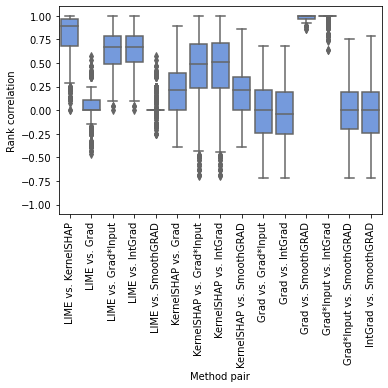

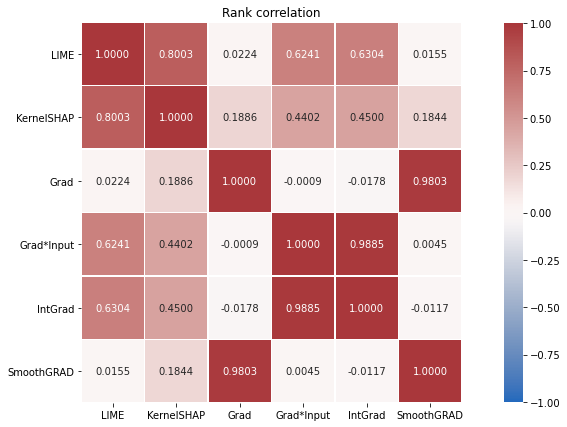

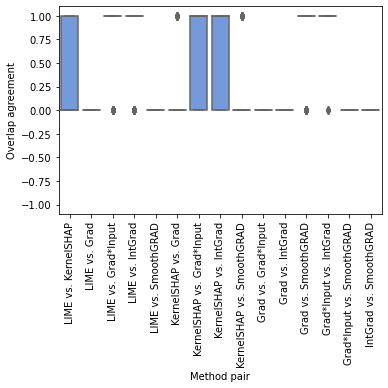

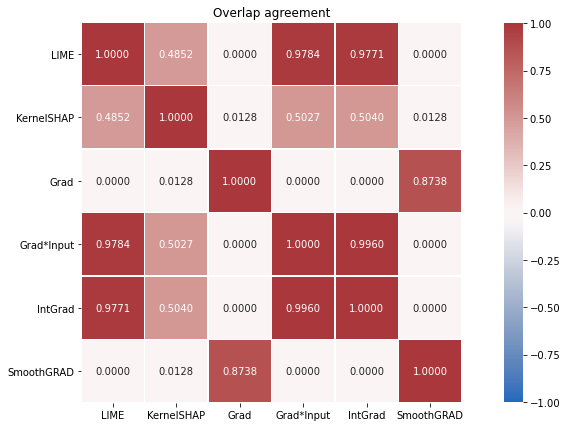

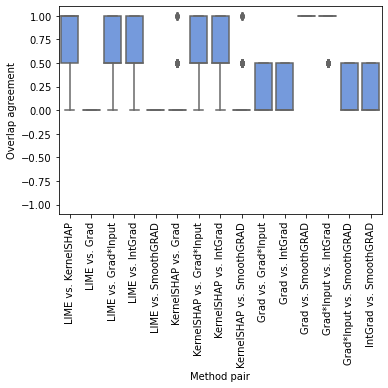

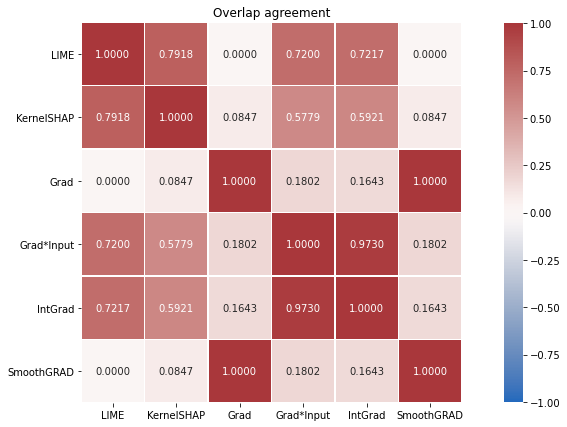

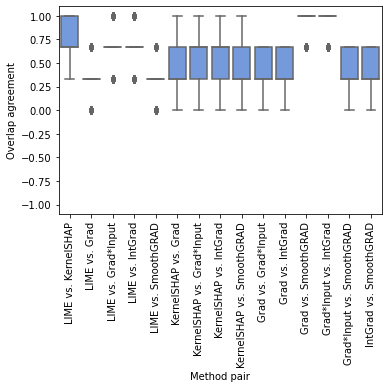

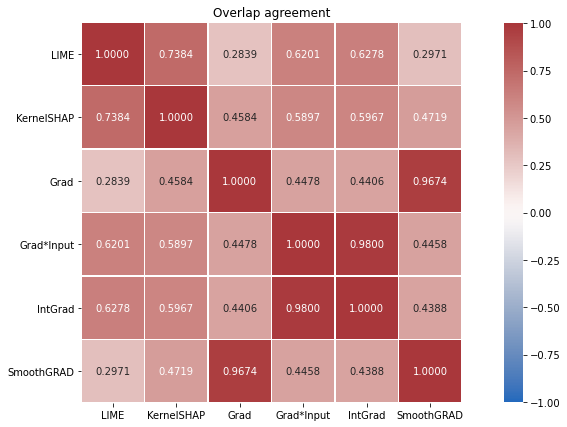

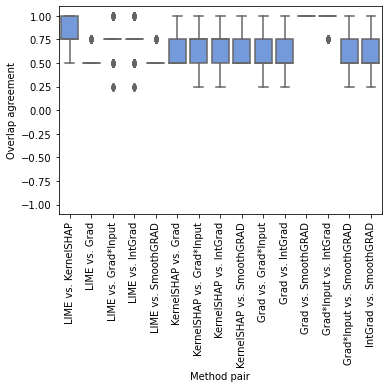

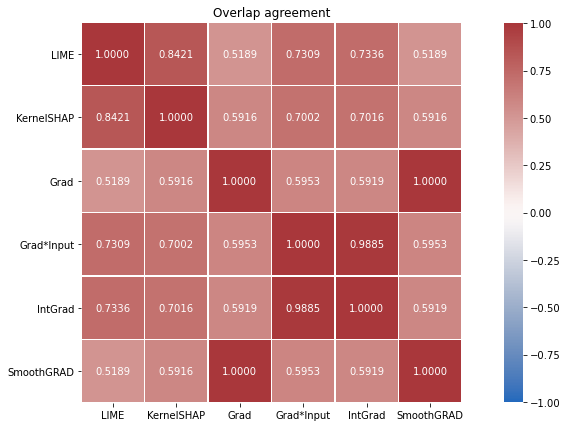

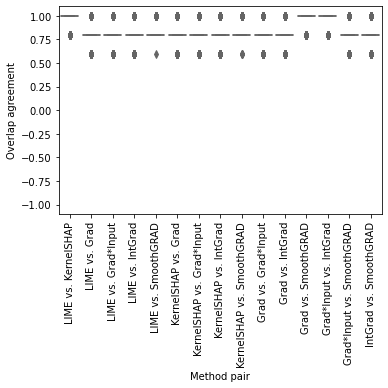

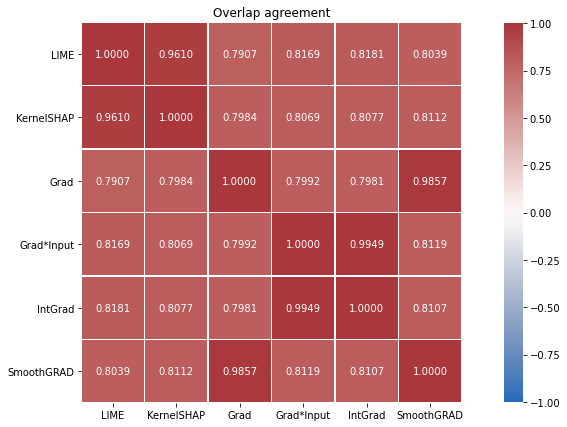

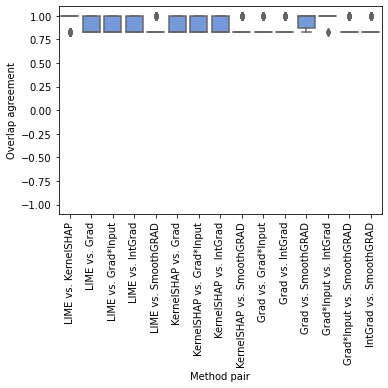

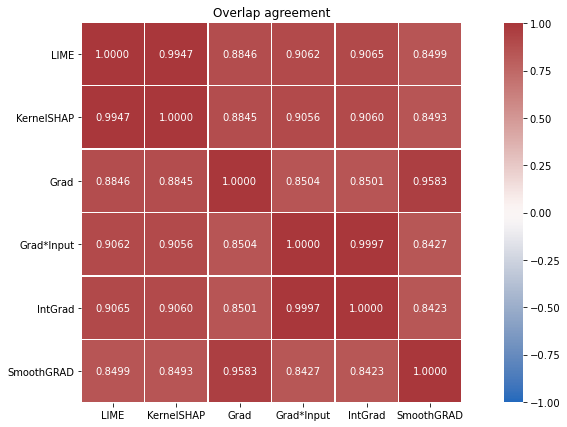

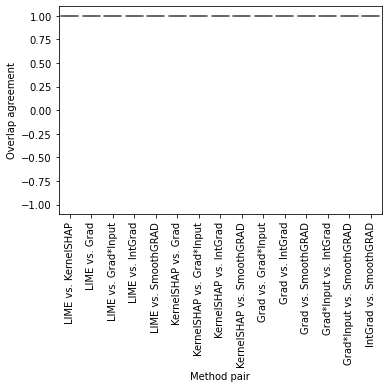

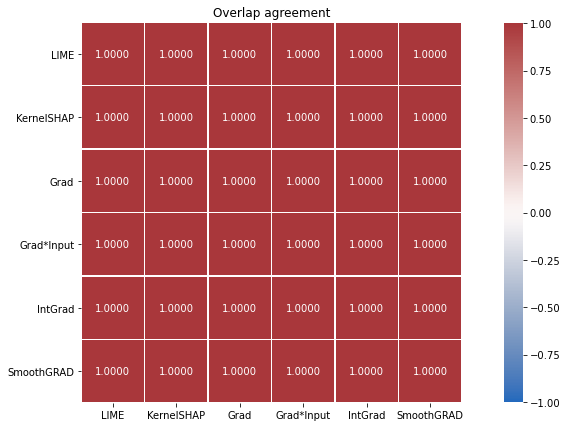

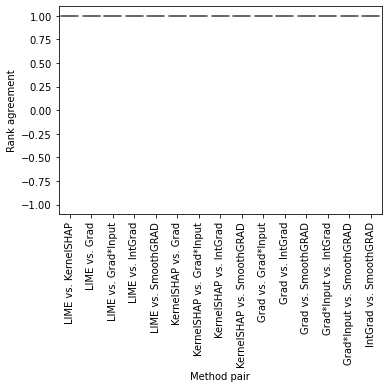

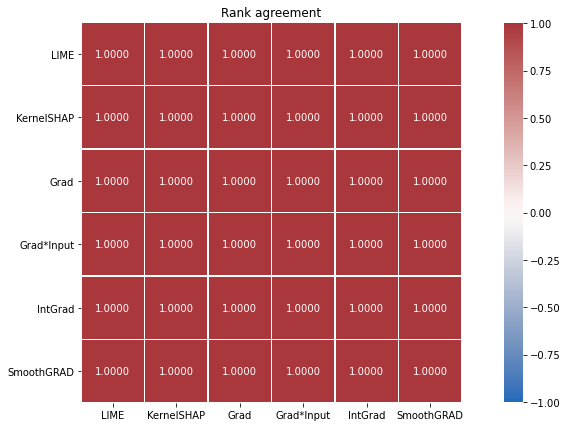

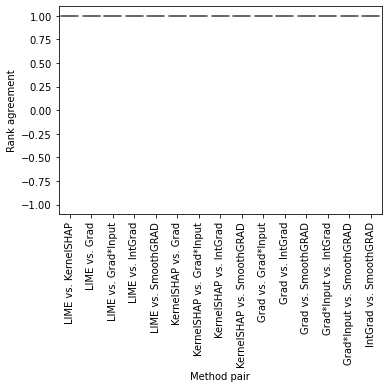

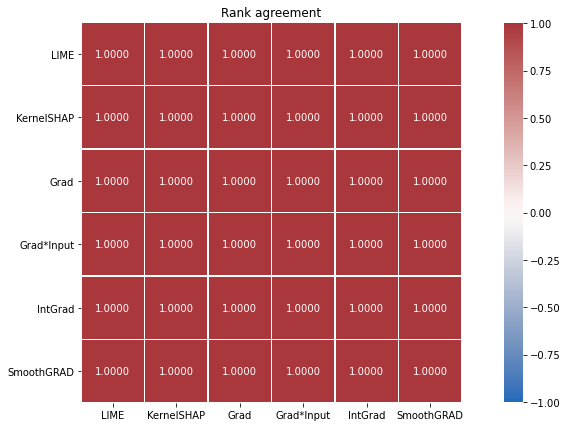

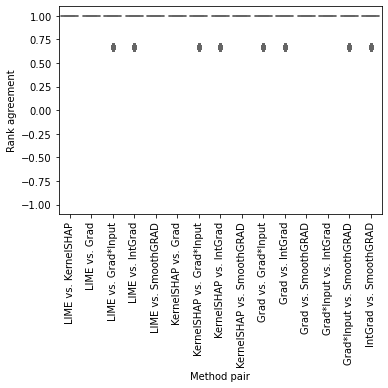

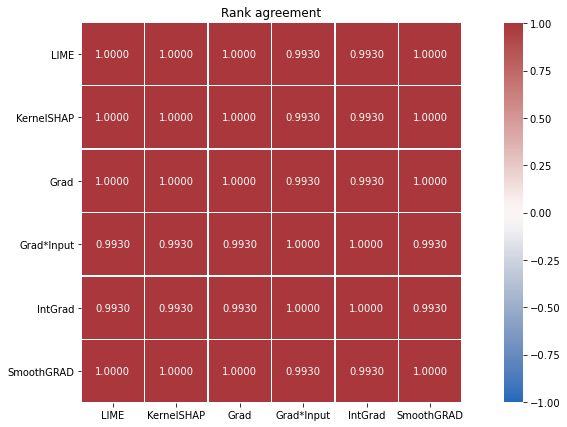

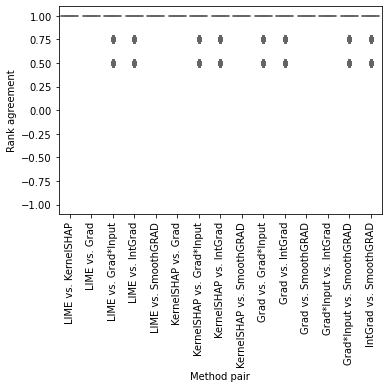

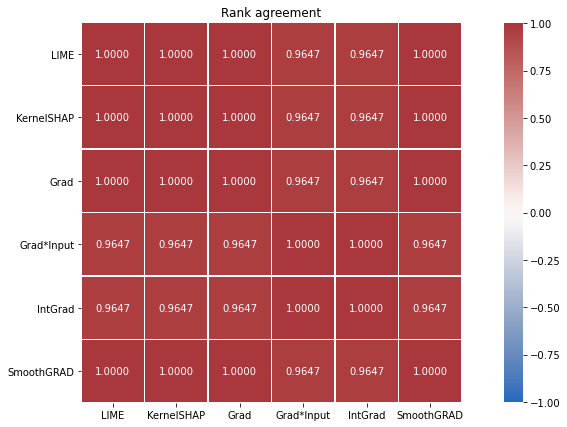

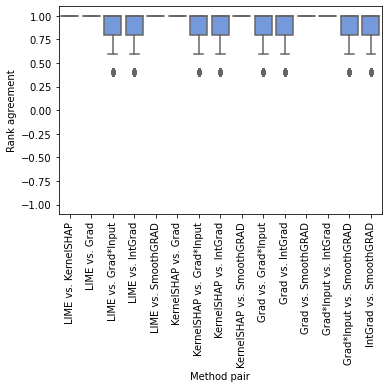

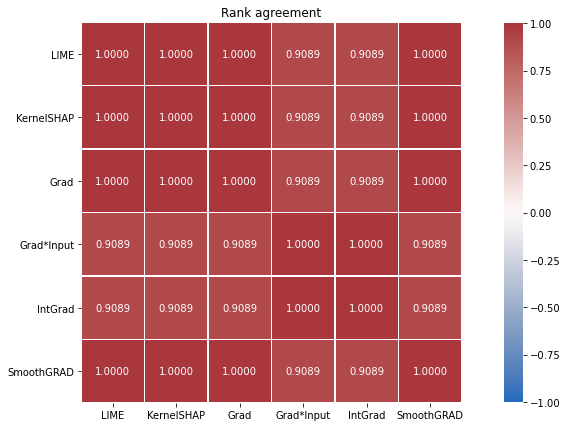

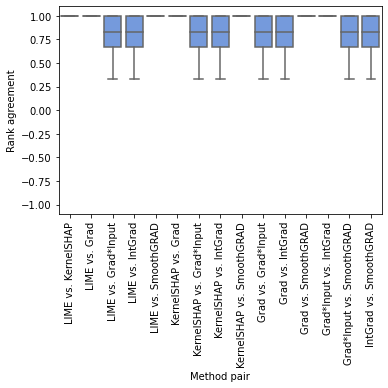

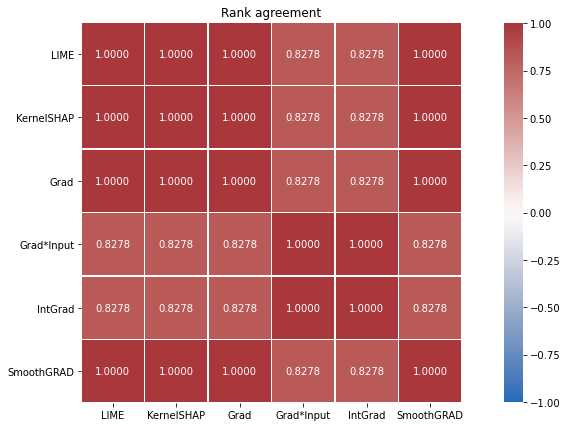

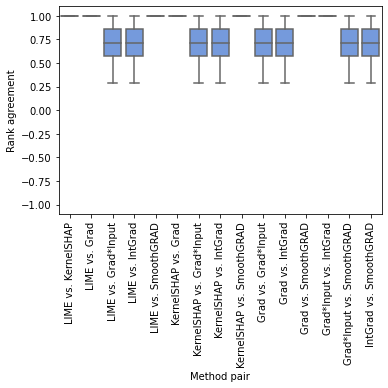

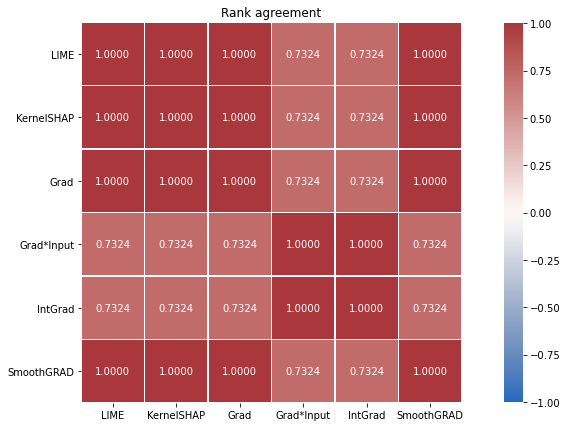

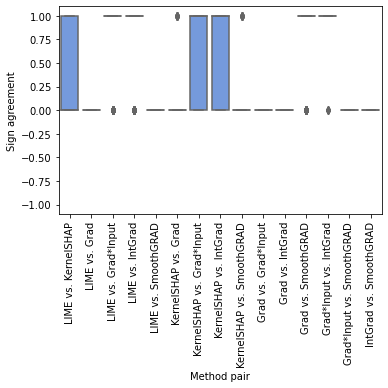

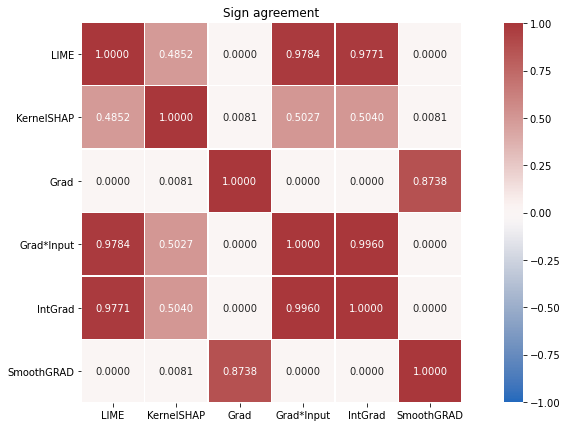

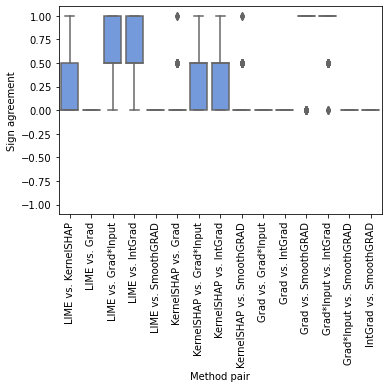

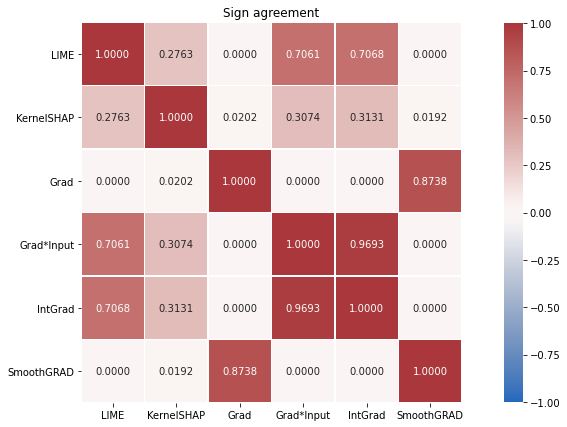

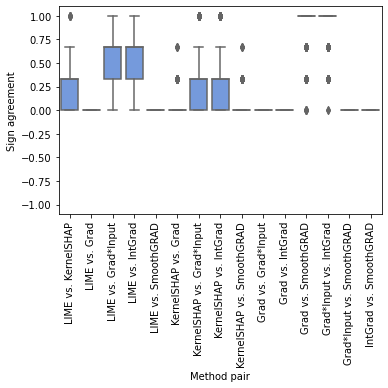

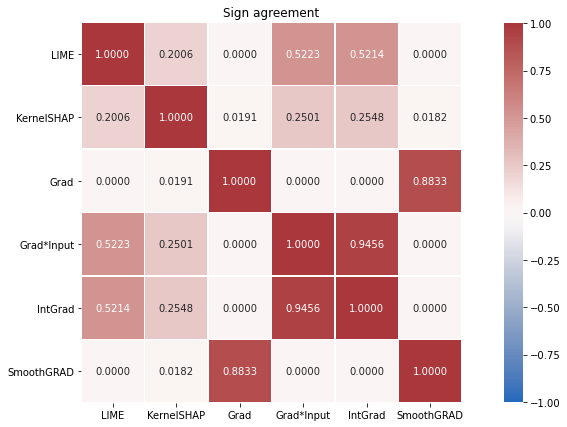

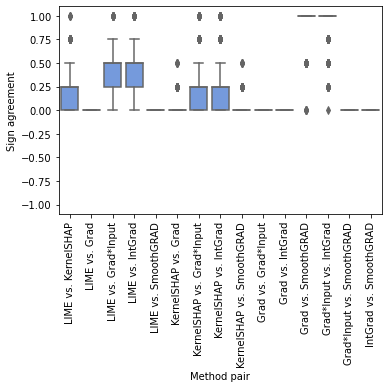

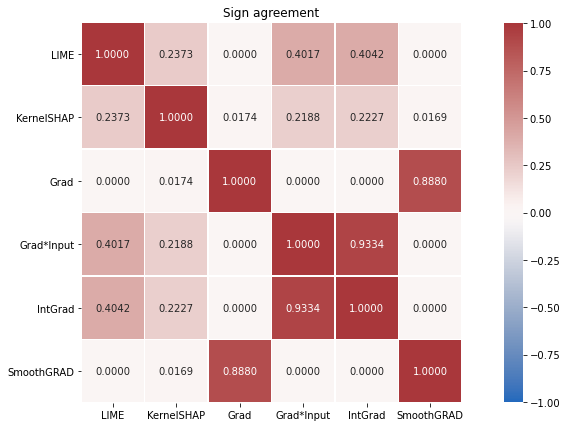

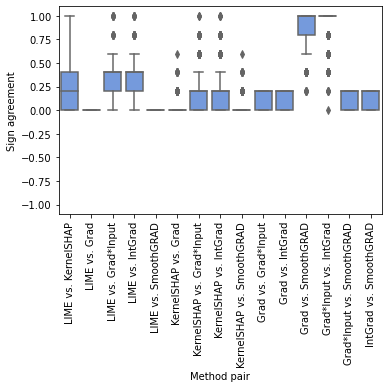

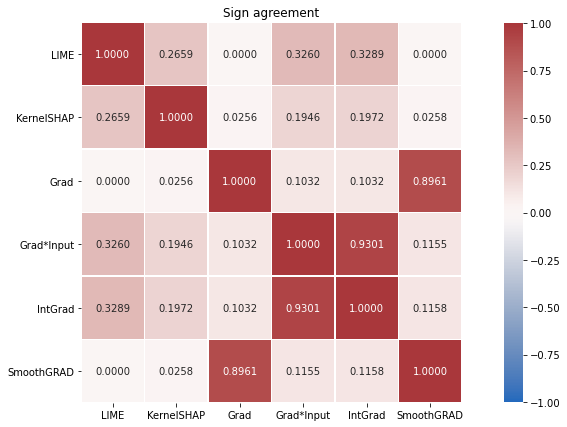

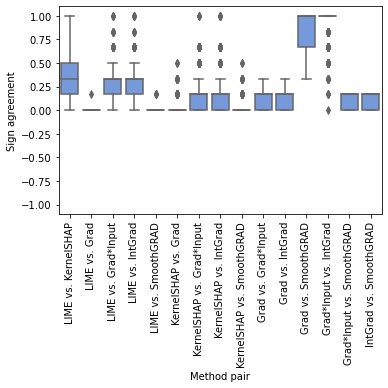

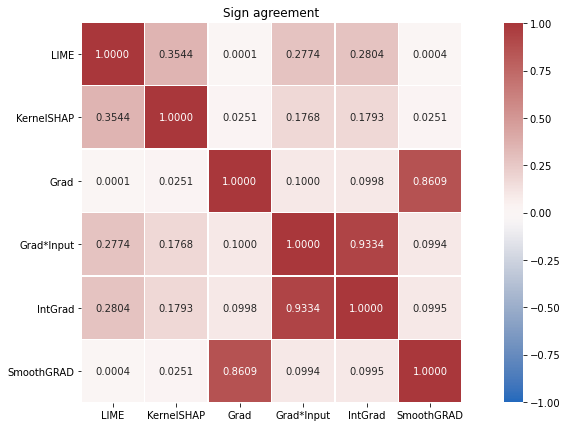

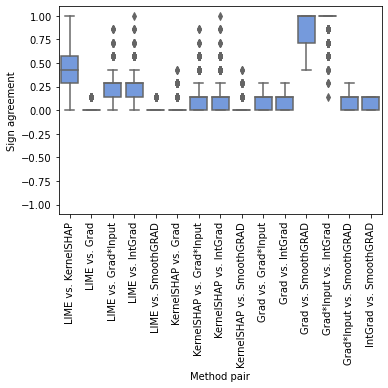

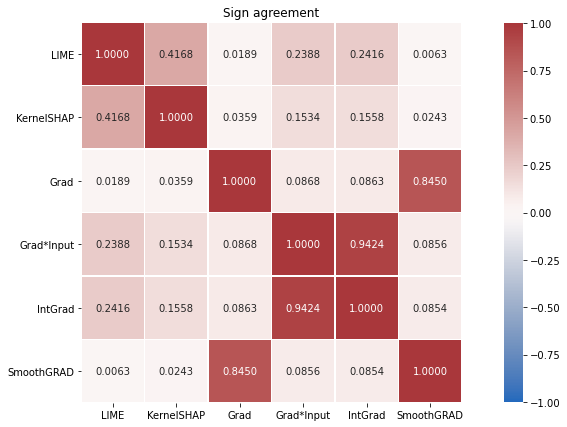

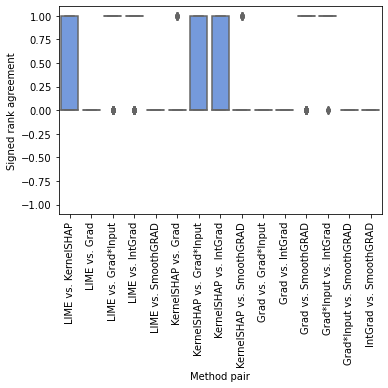

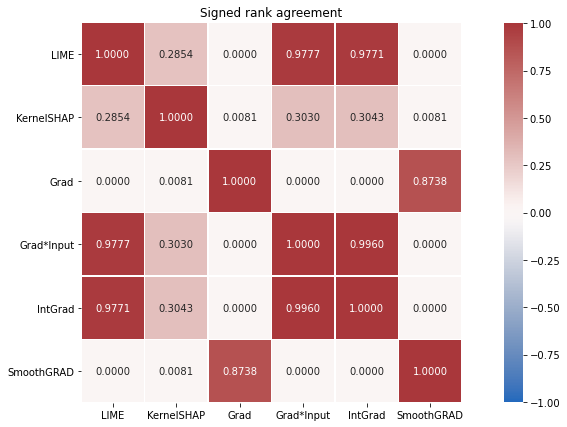

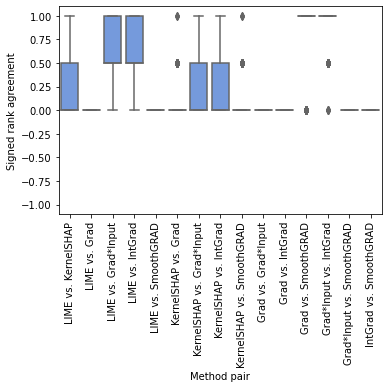

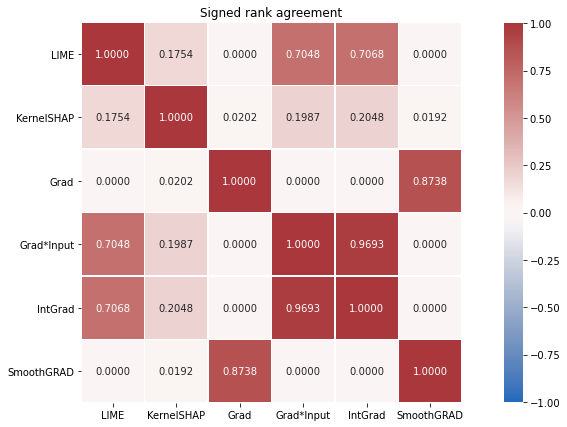

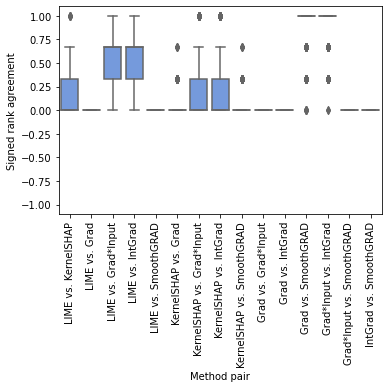

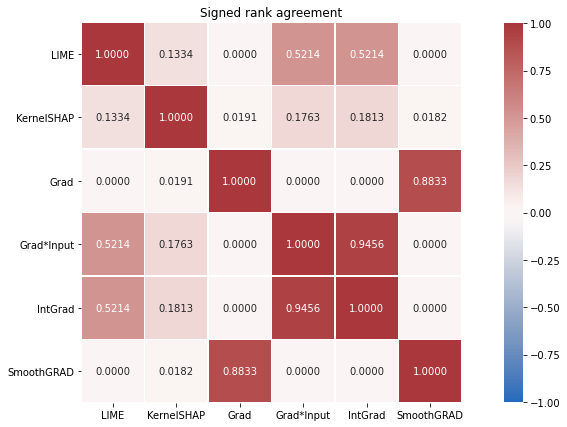

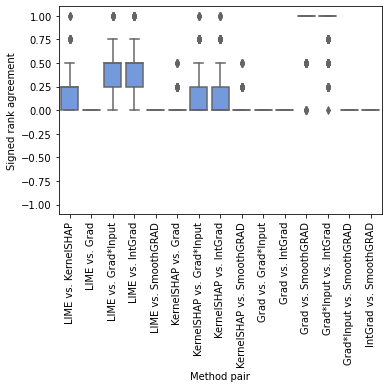

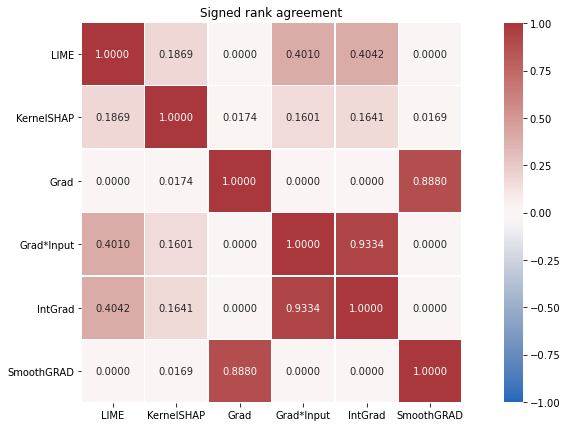

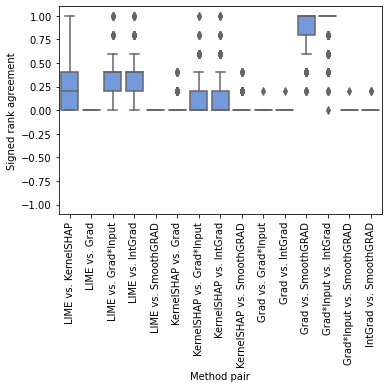

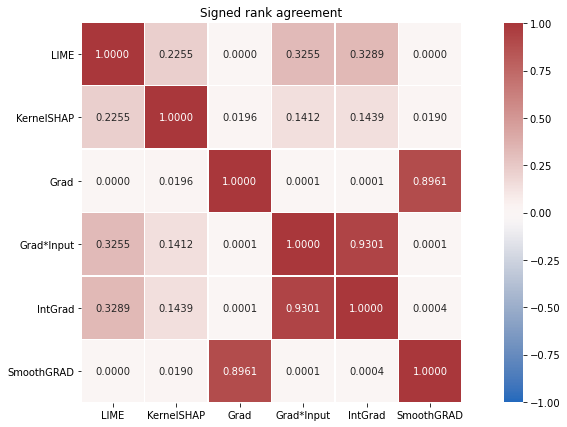

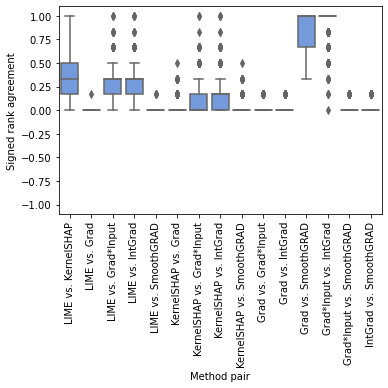

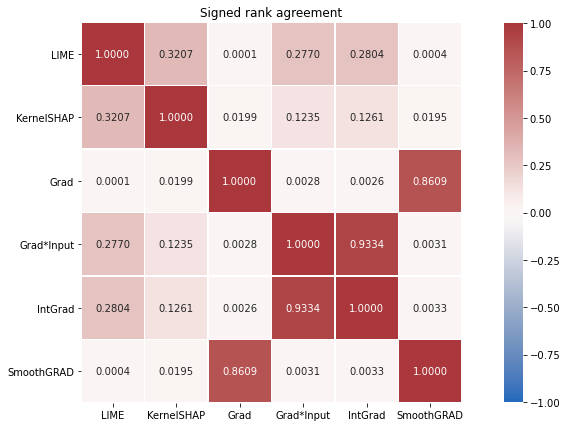

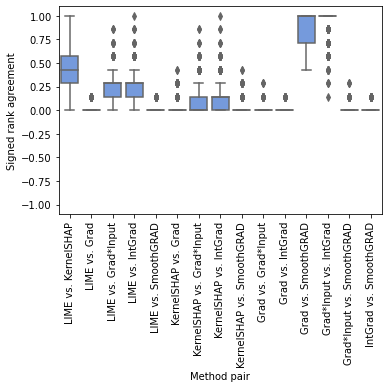

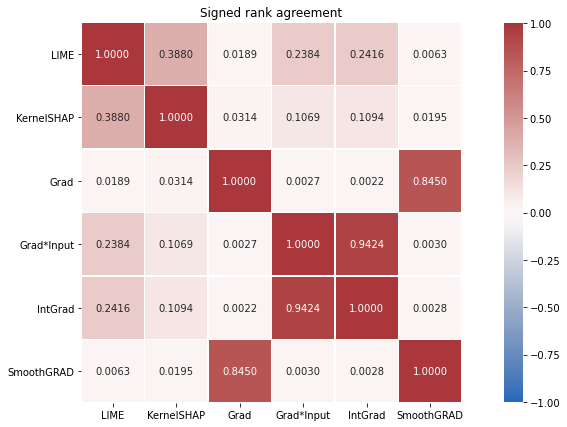

In [11]:
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}

models_list = ['nn']
#models_list = ['nn', 'nn_logistic']
metrics_list = ['rankcorr', 'overlap', 'rank', 'sign', 'ranksign']
#metrics_list = ['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign']
ks_list = [1, 2, 3, 4, 5, 6, 7]

for model in models_list:
    expl_methods_attrs = {0: attr_lime[model],
                          1: attr_kernelshap[model], 
                          2: attr_vanillagrad[model],
                          3: attr_gradtinput[model],
                          4: attr_integratedgrad[model],
                          5: attr_smoothgrad[model]}


    for metric in metrics_list:
        print(f'----------- calculating: {model}, {metric}')
        if metric in ['overlap', 'rank', 'sign', 'ranksign']:
            for k in ks_list:
                method_pairs_distr, method_pairs_avg = metric_analysis(expl_methods_names, expl_methods_attrs, k, f'figures/{model}', metric)
        else:
            k=0 #arbitrary (these metrics don't use k)
            method_pairs_distr, method_pairs_avg = metric_analysis(expl_methods_names, expl_methods_attrs, k, f'figures/{model}', metric)
        #print matrix of avg values     
        print(method_pairs_avg)
    